<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Mexican-hat-shaped-base-curves" data-toc-modified-id="Mexican-hat-shaped-base-curves-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Mexican-hat-shaped base curves</a></span></li><li><span><a href="#plot-base-set" data-toc-modified-id="plot-base-set-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>plot base set</a></span></li><li><span><a href="#Moment-Computing" data-toc-modified-id="Moment-Computing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Moment Computing</a></span></li><li><span><a href="#Build-a-dataset" data-toc-modified-id="Build-a-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Build a dataset</a></span></li><li><span><a href="#Data-augmentation-using-SMOTE" data-toc-modified-id="Data-augmentation-using-SMOTE-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Data augmentation using SMOTE</a></span></li><li><span><a href="#Principal-Component-analysis" data-toc-modified-id="Principal-Component-analysis-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Principal Component analysis</a></span></li></ul></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#binary-Classification" data-toc-modified-id="binary-Classification-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>binary Classification</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Logistic Regression Model</a></span></li><li><span><a href="#Neural-Networks" data-toc-modified-id="Neural-Networks-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Neural Networks</a></span><ul class="toc-item"><li><span><a href="#sklearn" data-toc-modified-id="sklearn-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>sklearn</a></span></li><li><span><a href="#tensorflow" data-toc-modified-id="tensorflow-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>tensorflow</a></span></li></ul></li></ul></li><li><span><a href="#Multiclass-Classification" data-toc-modified-id="Multiclass-Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Multiclass Classification</a></span><ul class="toc-item"><li><span><a href="#sub-groups-Classification" data-toc-modified-id="sub-groups-Classification-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>sub-groups Classification</a></span></li><li><span><a href="#Entire-classes-classification" data-toc-modified-id="Entire-classes-classification-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Entire classes classification</a></span></li></ul></li></ul></li></ul></div>

## Feature Engineering 

In [2]:
import pickle
import dill 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
#import seaborn as sns 
import os 
from collections import OrderedDict
from collections import Counter

%matplotlib inline 

# from scipy import fftpack
# from scipy.fftpack import fft, ifft
# from scipy import signal
# from scipy.optimize import curve_fit

from sklearn.decomposition import PCA 

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 
np.set_printoptions(precision=4)

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
motions = dill.load(open("motions070120.pickle", "rb"))

### Mexican-hat-shaped base curves 

fast/LR/5m, 0, : 0.2125372042211356


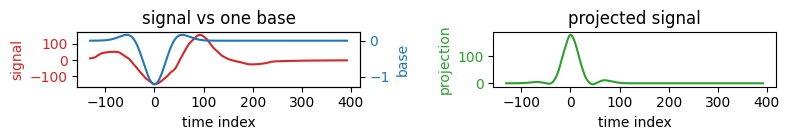

In [4]:
def base_Mexican_hat(x_range, a=40, b=5):
    A = 2/np.sqrt(3*a)*np.pi**(1/4)*b
    return -A*(1 - x_range**2/a**2)*np.exp(-x_range**2/a**2)


def plot_signal_with_base(base, class_name, curve_num):
    
    fig = plt.figure(figsize=(8,1.5), dpi=100, constrained_layout=False)
    axs = fig.subplots(1, 2)
    
#    fig, ax1 = plt.subplots(figsize=(4,1.5), dpi=100)

    X_ = motions.filteredMotions[class_name][curve_num]

    direction = class_name.split("/")[1]
    if direction == "LR":
        loc_peak = np.argmin(X_)
        phase = 1 
    else:
        loc_peak = np.argmax(X_)
        phase = -1
        
    x_range = np.arange(-loc_peak, loc_peak*3)
    y_signal = X_[:len(x_range)]
    y_base = phase * base(x_range)
    y_moment_computing = y_signal*y_base 
        
    color = 'tab:red'
    axs[0].set_xlabel('time index')
    axs[0].set_ylabel('signal', color=color)
    axs[0].plot(x_range, y_signal, color=color)
    axs[0].tick_params(axis='y', labelcolor=color)
    axs[0].set_title('signal vs one base')
    ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('base', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_range, y_base, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'tab:green'
    axs[1].set_xlabel('time index')
    axs[1].set_ylabel('projection', color=color)
    axs[1].plot(x_range, y_moment_computing, color=color)
    axs[1].tick_params(axis='y', labelcolor=color)
    axs[1].set_title('projected signal')
    moment_computing = np.dot(x_range, y_base)
    print("{}, {}, : {}".format(class_name, curve_num, moment_computing))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()    
    
plot_signal_with_base(base_Mexican_hat, 'fast/LR/5m', 0)

fast/RL/1m, 0, : -63.52856835109816


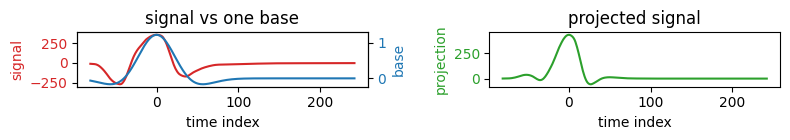

In [5]:
plot_signal_with_base(base_Mexican_hat, 'fast/RL/1m', 0)

In [6]:
classes_dict = {class_name: i for i,class_name in enumerate(motions.classes)} 
classes_dict    

{'fast/LR/1m': 0,
 'fast/LR/2m': 1,
 'fast/LR/3m': 2,
 'fast/LR/4m': 3,
 'fast/LR/5m': 4,
 'fast/LR/left': 5,
 'fast/LR/right': 6,
 'fast/RL/1m': 7,
 'fast/RL/2m': 8,
 'fast/RL/3m': 9,
 'fast/RL/4m': 10,
 'fast/RL/5m': 11,
 'fast/RL/left': 12,
 'fast/RL/right': 13,
 'slow/LR/1m': 14,
 'slow/LR/2m': 15,
 'slow/LR/3m': 16,
 'slow/LR/4m': 17,
 'slow/LR/5m': 18,
 'slow/LR/left': 19,
 'slow/LR/right': 20,
 'slow/RL/1m': 21,
 'slow/RL/2m': 22,
 'slow/RL/3m': 23,
 'slow/RL/4m': 24,
 'slow/RL/5m': 25,
 'slow/RL/left': 26,
 'slow/RL/right': 27}

In [7]:
def base_set(x_range):
    num_base = 20 
    a0 = 10
    b = 5 # fixed 
    da = 5
    y_base = np.zeros(shape=(num_base, len(x_range)))
    for i in range(num_base): 
        a = a0 + i*da 
        A = 2/np.sqrt(3*a)*np.pi**(1/4)*b
        y_base[i] = -A*(1 - x_range**2/a**2)*np.exp(-x_range**2/a**2)
        
    return y_base


def cal_momentComputing(class_name):

    num_base = 20 
    moment_computing = [] 
    signals = motions.filteredMotions[class_name]
    
    direction = class_name.split("/")[1]
    
    moment_computing =[]
    
    for i, sig in enumerate(signals):

        if direction == "LR":
            loc_peak = np.argmin(sig)
            phase = 1 
        else:
            loc_peak = np.argmax(sig)
            phase = -1
        
        #loc_peak = np.argmin(sig)
        x_range = np.arange(-loc_peak, loc_peak*3)

        if len(x_range) > 1200: 
            continue 

        y_signal = sig[:len(x_range)]
        y_bases = phase*base_set(x_range)
                
        vec_set = [] 
        for idx_vec in range(num_base):
            vec_set.append(np.dot(y_signal, y_bases[idx_vec]))
            
        vec_set.append(class_name)

        moment_computing.append(vec_set)
    
    return moment_computing


### plot base set 

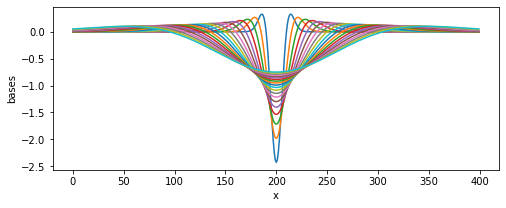

In [8]:
y_bases = base_set(np.arange(-200,200))
plt.figure(figsize=(8,3))
for y in y_bases:
    plt.plot(y)
_=plt.ylabel("bases")
_=plt.xlabel("x")

### Moment Computing 

In [9]:
dist = {} 
moment_collection = [] 
for class_name in motions.classes:     
    moment = cal_momentComputing(class_name)
    for m in moment: 
        moment_collection.append(m)
#    print(class_name, motions.filteredMotions[class_name].shape[0])
    dist[class_name] = motions.filteredMotions[class_name].shape[0]


### Build a dataset 

In [10]:
df = pd.DataFrame(np.array(moment_collection))
df.columns=['base'+str(i+1) for i in range(20)] + ['class_name']
display(df.head())
display(df.tail())

,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,...,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
0,10563.790067539232,13653.800646394604,16373.345212055385,18420.52051018493,19617.047945281414,19994.98015804572,19706.814659610747,18938.129594854287,17861.577730953577,16617.58141378464,...,14009.030516970923,12759.351935163075,11586.01188231587,10501.176146197411,9508.619094515681,8606.97814721386,7791.935407211868,7057.627433044193,6397.528716941249,fast/LR/1m
1,14626.511350111627,18298.532434077493,21288.442088559008,23439.7529241143,24547.690075483973,24630.82050869769,23898.01721502633,22614.586066852564,21017.747869657098,19287.234497681107,...,15867.93444837648,14297.43111612093,12853.703293842067,11542.411095774101,10360.750941869375,9301.261159854359,8354.234433646707,7509.188093691231,6755.720148668153,fast/LR/1m
2,13416.759507009385,17209.525601739384,20526.1254463387,23048.464672173115,24579.887534910078,25131.156608557474,24857.0101686197,23967.45510960245,22668.738248401645,21134.462179243623,...,17848.064829375202,16248.994597531939,14735.493641931578,13326.437448969906,12029.237374480139,10844.041497654265,9766.676168978425,8790.617719475526,7908.260380934733,fast/LR/1m
3,17343.086503127633,21930.841082921608,25748.68589053599,28627.548853298897,30344.271836734406,30861.109714755497,30349.025878844317,29080.198912045962,27330.15022895009,25327.348528183968,...,21178.105872260494,19211.809515538167,17377.522601294753,15691.436397812598,14156.606517208807,12768.325887218252,11517.680972786497,10393.805284268677,9385.246384640264,fast/LR/1m
4,18633.83032061867,23818.49289762111,28228.84944438396,31621.875465128738,33790.2091118597,34691.73433263716,34473.24636736879,33392.029763273575,31725.700613137014,29717.087189105267,...,25367.032443226824,23243.330006835356,21233.439587905275,19363.937014474133,17645.171355634266,16077.274023179429,14654.333037190147,13367.172791110437,12205.135184929217,fast/LR/1m


,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,...,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
4445,9987.771059467894,12743.498590264904,15254.384477811655,17321.763559832536,18775.20974782702,19575.31814493686,19785.72825275699,19521.287501001545,18905.4242028211,18046.09984544919,...,15916.835170362094,14759.071292308465,13590.980458456977,12439.179133561898,11323.110344278615,10256.455317780234,9248.240803885128,8303.778994746091,7425.487415275792,slow/RL/right
4446,10946.551995957538,13742.39470321285,16061.759532472039,17924.18310529258,19372.995444990094,20494.532443874275,21368.26856798322,22029.462341124487,22473.655032452974,22681.997899124915,...,22365.94260304801,21873.28780772874,21201.681648220583,20391.81562570437,19483.812928917258,18513.881814448905,17512.681845605126,16504.903973974186,15509.585020018163,slow/RL/right
4447,11303.616446059867,14126.632082436172,16708.54405266654,19108.108580596112,21214.23705457624,22915.345263202766,24145.580641232256,24882.300079049684,25142.811663937027,24977.39243768291,...,23662.578142011647,22670.26258691198,21549.097097334896,20355.81587172212,19134.83047524756,17919.302301448977,16732.893960371428,15591.661502612375,14505.800039002042,slow/RL/right
4448,11843.83420248743,14764.615700045044,17241.012181359452,19394.42218036394,21259.61791977365,22801.290999513876,23972.397324186466,24740.478876549947,25099.56301476561,25074.419479331398,...,24089.306544830637,23264.31240645762,22305.055337012258,21266.26690348268,20191.652560629478,19114.343284196017,18058.28787794776,17039.943320578168,16069.912916612106,slow/RL/right
4449,19394.327369963277,24445.243589602338,28958.75044267886,32878.21155372953,36079.027444048115,38465.71816159808,40025.80890463102,40821.72971136535,40958.610429029424,40556.88283755485,...,38598.31724506678,37238.57114373884,35730.137051186,34132.887998664635,32493.7258978917,30848.57373112656,29224.271772662927,27640.288203581447,26110.213984698257,slow/RL/right


### Data augmentation using SMOTE

In [11]:
import imblearn
from imblearn.over_sampling import SMOTE 

y_org = df['class_name'].values
x_org = df.iloc[:,:20].values 

sm = SMOTE(random_state=42)
X_augmented, y_augmented = sm.fit_resample(x_org, y_org)

### Principal Component analysis

In [12]:
subClass = [] 

for class_name in motions.classes: 
    s = os.path.join(*class_name.split("/")[1:]) 
    if s not in subClass: 
        subClass.append(s)
    
print(subClass)

['LR/1m', 'LR/2m', 'LR/3m', 'LR/4m', 'LR/5m', 'LR/left', 'LR/right', 'RL/1m', 'RL/2m', 'RL/3m', 'RL/4m', 'RL/5m', 'RL/left', 'RL/right']


In [13]:
pairClass = [] 
for s in subClass: 
    pairClass.append(['fast/'+s, 'slow/'+ s])
    
for p in pairClass:
    print(p)

['fast/LR/1m', 'slow/LR/1m']
['fast/LR/2m', 'slow/LR/2m']
['fast/LR/3m', 'slow/LR/3m']
['fast/LR/4m', 'slow/LR/4m']
['fast/LR/5m', 'slow/LR/5m']
['fast/LR/left', 'slow/LR/left']
['fast/LR/right', 'slow/LR/right']
['fast/RL/1m', 'slow/RL/1m']
['fast/RL/2m', 'slow/RL/2m']
['fast/RL/3m', 'slow/RL/3m']
['fast/RL/4m', 'slow/RL/4m']
['fast/RL/5m', 'slow/RL/5m']
['fast/RL/left', 'slow/RL/left']
['fast/RL/right', 'slow/RL/right']


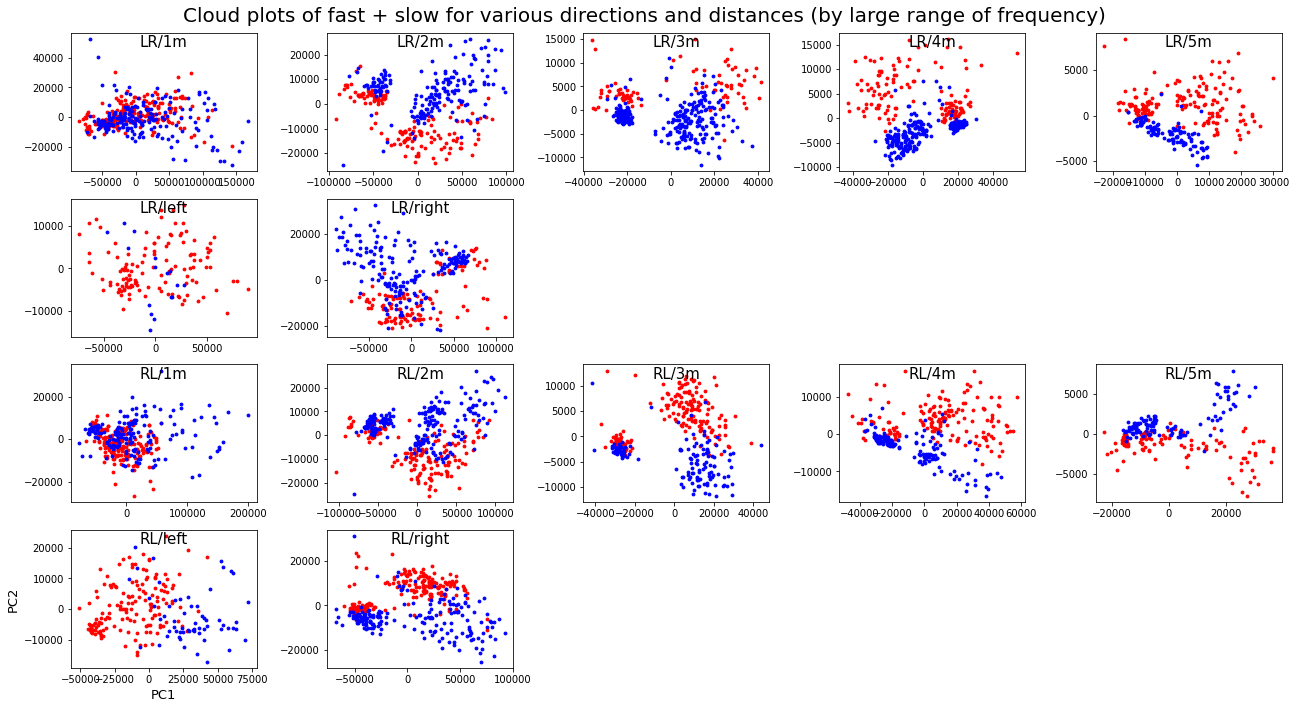

In [14]:
def PCA_for_speeds(class_pair):
    class1, class2 = class_pair
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    target = df_fs.pop('class_name') 
    target.reset_index(drop=True,inplace=True) 
    X = df_fs
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns = ['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, target], axis = 1)
    
    return finalDf
    

def ListPlotClouds(): 
    
    fig = plt.figure(figsize=(18, 10), constrained_layout=False)
    n_row, n_col = 4, 5
    axs = fig.subplots(n_row, n_col)
    plt.suptitle("Cloud plots of fast + slow for various directions and distances (by large range of frequency)", 
                 fontsize=20)
    
    idx_pair = 0 
    for r in range(n_row):         
        for c in range(n_col):
            if r%2==1 and c > 1: 
                axs[r, c].axis('off')
            else: 
                axs[r, c].set_title(str(subClass[idx_pair]), 
                                    y=1.0, pad=-14, 
                                    c='k', 
                                    fontsize=15)
                df_pc = PCA_for_speeds(pairClass[idx_pair])
                class1,class2 = pairClass[idx_pair]
                df_cl1 = df_pc[df_pc['class_name']==class1]
                df_cl2 = df_pc[df_pc['class_name']==class2]
                axs[r, c].scatter(df_cl1['PC1'], df_cl1['PC2'], c='red', s=8)
                axs[r, c].scatter(df_cl2['PC1'], df_cl2['PC2'], c='blue', s=8)
                
                idx_pair +=1
    
    axs[3,0].set_xlabel('PC1', fontsize=13)
    axs[3,0].set_ylabel('PC2', fontsize=13)
    
    plt.tight_layout()
    plt.savefig('cloudPlotFordifferentSpeeds_largerRange.pdf')  

ListPlotClouds()

## Predictive models

### binary Classification 
#### Logistic Regression Model 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [16]:
def logisticRegression(class1, class2):
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    df_fs = shuffle(df_fs)
    df_fs.reset_index(drop=True,inplace=True)
    
    n = df_fs.shape[0]
    train_df = df_fs[0:int(n*0.8)]
    test_df = df_fs[int(n*0.8):]

    train_y = train_df.pop('class_name')
    train_X = train_df  

    test_y = test_df.pop('class_name')
    test_X = test_df  

    clf = LogisticRegression(random_state=0).fit(train_X, train_y)

    return clf.score(test_X, test_y)

print(logisticRegression('fast/LR/1m', 'slow/LR/1m'))
print(logisticRegression('fast/LR/3m', 'slow/LR/3m'))
print(logisticRegression('fast/LR/5m', 'slow/LR/5m'))

0.6976744186046512
0.9
0.9636363636363636


In [17]:
print(logisticRegression('fast/RL/1m', 'slow/RL/1m'))
print(logisticRegression('fast/RL/3m', 'slow/RL/3m'))
print(logisticRegression('fast/RL/5m', 'slow/RL/5m'))

0.7887323943661971
0.8307692307692308
0.9583333333333334


In [18]:
print(logisticRegression('fast/RL/left', 'slow/RL/left'))
print(logisticRegression('fast/RL/right', 'slow/RL/right'))

0.8372093023255814
0.925


In [19]:
print(logisticRegression('fast/LR/left', 'slow/LR/left'))
print(logisticRegression('fast/LR/right', 'slow/LR/right'))

0.9642857142857143
0.9032258064516129


#### Neural Networks 

In [20]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing


In [21]:
def get_speeds_data(class1, class2):
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    df_fs = shuffle(df_fs)
    df_fs.reset_index(drop=True,inplace=True)
    
    return df_fs

In [22]:
df_fs = get_speeds_data('fast/LR/1m', 'slow/LR/1m')
display(df_fs)

,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,...,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
0,23010.07956136328,29403.11223923959,34727.92649462703,38565.890812101425,40640.792071497344,40967.45031908862,39833.05384098325,37652.28819324913,34832.297254930745,31703.44332516205,...,25386.554108457294,22445.836138500756,19728.891269471253,17254.43277204936,15022.953245686884,13024.254361098288,11242.403909099801,9658.88788729383,8254.545615319845,slow/LR/1m
1,8214.49570782583,10282.924894945296,11828.051326721941,12824.448790009845,13214.654052602476,13035.223354836146,12423.790232925925,11546.94686692629,10546.058479878046,9520.085228329677,...,7606.999836249999,6766.586079524079,6011.580311288308,5339.132864097664,4743.331669937056,4217.0034244735925,3752.7294051040863,3343.3831019353365,2982.3871060036786,fast/LR/1m
2,3364.4144993219347,4293.583482873426,5071.048672531077,5513.106411831386,5578.174469132455,5346.61453168182,4935.85650562136,4444.265349800982,3936.6119540272643,3449.519027766732,...,2597.3790324936126,2239.7227128089808,1925.4419621402271,1650.7033797605059,1411.221173762149,1202.7468563427865,1021.3107443274242,863.3260613196006,725.618118680759,fast/LR/1m
3,13561.387862724654,17122.45404365671,19868.896166437014,21687.9954237161,22481.614131799288,22310.451204467558,21395.301787540826,20005.57480580578,18373.76024889578,16667.044806665,...,13409.142102732247,11948.861821972856,10621.881711524438,9427.695128535252,8359.59602007278,7407.856517292903,6561.6170826836715,5809.962355805861,5142.4978999656,fast/LR/1m
4,14483.174790748944,18110.300829196607,21061.717876998628,23311.45330904774,24664.373783695875,25053.278918132666,24601.402430654394,23527.76895461285,22058.378799814178,20381.713959355307,...,16915.361095722517,15275.225642818776,13746.941799090815,12344.111974232046,11069.385956450722,9918.887110688658,8885.152404368493,7959.011300272839,7130.741992054039,slow/LR/1m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,11742.573603339531,14819.64957478878,17305.769172338427,18894.83410549016,19415.291335554015,18987.25843737544,17890.4027815765,16409.650042251942,14765.869644464976,13106.179000836231,...,10046.252760294155,8710.288100535454,7512.909792654411,6448.364726277074,5506.580094333485,4675.789681721028,3944.019182604502,3299.868843523477,2732.8782412477467,fast/LR/1m
426,6258.66718338674,8096.438537507057,9623.254362171458,10698.139341343162,11262.639843984376,11354.34132909639,11070.545535954137,10527.747816725643,9831.487536657454,9063.166460627459,...,7515.565210970821,6793.305879299258,6123.378807477233,5510.220382790614,4954.2430438272,4453.481694436332,4004.6482061566257,3603.79375299248,3246.7198137249998,slow/LR/1m
427,13149.734492730078,16731.650948859904,19504.595772452118,21298.53451195169,22001.896759966367,21712.89877429659,20687.318480310336,19209.156347936118,17511.657315216657,15757.27561065591,...,12437.13924563319,10955.134344313137,9610.474055278935,8402.413397319002,7324.597892567145,6367.84462965523,5521.760764684646,4775.675598999432,4119.174563357946,fast/LR/1m
428,16190.119321573478,20289.857547974294,23785.451651709198,26710.778557455174,28918.902712806637,30279.45333732896,30795.33299665653,30578.10238145999,29786.371640222387,28581.510490862376,...,25473.20383696215,23772.08370651948,22065.600750310557,20397.669338222586,18797.15401056251,17281.77016783005,15861.214285702557,14539.550109135911,13316.969381308863,slow/LR/1m


In [23]:
y = df_fs.pop('class_name')
X = df_fs.values

In [24]:
X.shape, y.shape

((430, 20), (430,))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

##### sklearn

In [26]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=20, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
def skln_binaryClassification(class1, class2):
    
    X = np.vstack((X_augmented[y_augmented == class1, :], 
                   X_augmented[y_augmented == class2, :]))
    y = np.hstack((y_augmented[y_augmented == class1], 
                   y_augmented[y_augmented == class2]))
    
    encoded_y = LabelEncoder().fit_transform(y)
    
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    results = cross_val_score(pipeline, X, encoded_y, cv=kfold)
    
    print("{} vs {}".format(class1, class2))
    print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [28]:
# skln_binaryClassification('fast/LR/1m', 'slow/LR/1m')
# skln_binaryClassification('fast/LR/5m', 'slow/LR/5m')
# skln_binaryClassification('fast/LR/1m', 'fast/RL/1m')
# skln_binaryClassification('fast/LR/5m', 'fast/RL/5m')

##### tensorflow

In [29]:
def plot_loss(history, epochs): 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.title('Training and Validation Loss')
    plt.show()


In [30]:
from sklearn.model_selection import train_test_split

# from keras import backend
# print(backend.tensorflow_backend._get_available_gpus())

In [31]:
def get_optimizer():
      return tf.keras.optimizers.Adam(learning_rate=0.01)


### Multiclass Classification 

#### sub-groups Classification 

In [202]:
def nn_binaryClassification(class1, class2, batch_size):

    X = np.vstack((X_augmented[y_augmented == class1, :], 
                   X_augmented[y_augmented == class2, :]))
    y = np.hstack((y_augmented[y_augmented == class1], 
                   y_augmented[y_augmented == class2]))
    
    print(X.shape, y.shape)
    
    # standardizing input features 
    scaled_X = StandardScaler().fit_transform(X)
    # ordinal encoding target value 
    encoded_y = LabelEncoder().fit_transform(y)
    
    # split into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, encoded_y, test_size=0.3, random_state=0)

    
    model = keras.Sequential([
        keras.layers.Dense(8, input_shape=(scaled_X.shape[1],),
                            activation=tf.nn.elu, 
                            kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5),
        keras.layers.Dense(1,activation=tf.nn.sigmoid),    
    ])

    model.compile(optimizer=get_optimizer(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epoch = 500 
    history = model.fit(X_train, y_train, epochs=epoch,  
                        validation_split=0.2, 
                        batch_size=batch_size,
                        verbose=0)
    
    model.evaluate(X_test, y_test)
    
    plot_loss(history, epochs=epoch)

(512, 20) (512,)


2021-08-15 17:05:04.842298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:05:05.013701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.5361 - accuracy: 0.7468


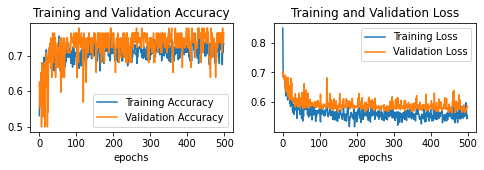

(512, 20) (512,)


2021-08-15 17:05:39.427641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:05:39.925341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 6ms/step - loss: 0.2423 - accuracy: 0.9351


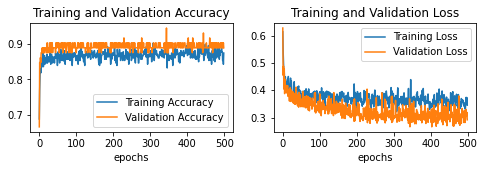

(512, 20) (512,)


2021-08-15 17:06:14.282968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:06:14.441949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.0851 - accuracy: 0.9805


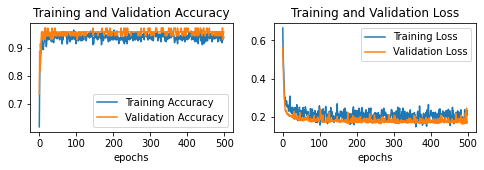

(512, 20) (512,)


2021-08-15 17:06:49.918000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:06:50.077543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.6039


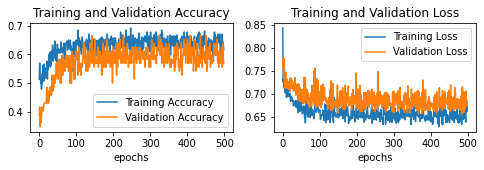

(512, 20) (512,)


2021-08-15 17:07:23.599578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:07:23.758907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.5846 - accuracy: 0.7143


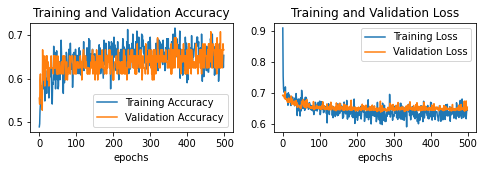

(512, 20) (512,)


2021-08-15 17:07:57.375316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:07:57.533818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.2670 - accuracy: 0.8896


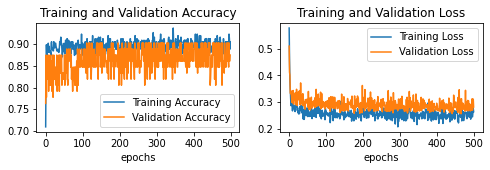

(512, 20) (512,)


2021-08-15 17:08:30.379123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 17:08:30.539426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 5ms/step - loss: 0.0208 - accuracy: 1.0000


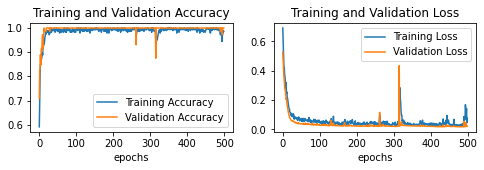

CPU times: user 3min 54s, sys: 2min 25s, total: 6min 19s
Wall time: 3min 58s


In [203]:
%%time 
batch_size = 32
nn_binaryClassification('fast/LR/1m', 'slow/LR/1m', batch_size)
nn_binaryClassification('fast/LR/3m', 'slow/LR/3m', batch_size)
nn_binaryClassification('fast/LR/5m', 'slow/LR/5m', batch_size)
nn_binaryClassification('slow/RL/1m', 'slow/LR/1m', batch_size)
nn_binaryClassification('fast/RL/1m', 'fast/LR/1m', batch_size)
nn_binaryClassification('fast/LR/right', 'fast/LR/left', batch_size)
nn_binaryClassification('slow/LR/right', 'slow/LR/left', batch_size)

In [42]:
motions.classes

['fast/LR/1m',
 'fast/LR/2m',
 'fast/LR/3m',
 'fast/LR/4m',
 'fast/LR/5m',
 'fast/LR/left',
 'fast/LR/right',
 'fast/RL/1m',
 'fast/RL/2m',
 'fast/RL/3m',
 'fast/RL/4m',
 'fast/RL/5m',
 'fast/RL/left',
 'fast/RL/right',
 'slow/LR/1m',
 'slow/LR/2m',
 'slow/LR/3m',
 'slow/LR/4m',
 'slow/LR/5m',
 'slow/LR/left',
 'slow/LR/right',
 'slow/RL/1m',
 'slow/RL/2m',
 'slow/RL/3m',
 'slow/RL/4m',
 'slow/RL/5m',
 'slow/RL/left',
 'slow/RL/right']

#### Entire classes classification 

In [199]:
def nn_multiClass_Classification(class_list, batch_size):
    
    n_classes = len(class_list)
    print("number of classes: {}".format(n_classes))
    
    y = []
    X_multiClass = []
    for m in class_list:
        X_multiClass.append(X_augmented[y_augmented == m])
        y.append(y_augmented[y_augmented == m])

    X = np.vstack(X_multiClass)
    y = np.hstack(y)
        
    # standardizing input features 
    scaled_X = StandardScaler().fit_transform(X)
    # ordinal encoding target value 
    encoded_y = LabelEncoder().fit_transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_y)
        
    # split into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, dummy_y, test_size=0.3, random_state=0)

    print("train set: ", X_train.shape, y_train.shape)
    print("test set: ",X_test.shape, y_test.shape)
    
    model = keras.Sequential([
        keras.layers.Dense(512, input_dim=X.shape[1], 
                           kernel_regularizer=regularizers.l2(0.001),
                           activation='elu'),
        Dropout(0.5),                
        keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                   activation='elu'),
        Dropout(0.5),                

        keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                   activation='elu'),
        Dropout(0.5),                

        keras.layers.Dense(n_classes, activation='softmax'),    
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    epoch = 500 
    history = model.fit(X_train, y_train, 
                        epochs=epoch,  
                        validation_split=0.2, 
                        batch_size=batch_size,
                        verbose=0)
    
    model.evaluate(X_test, y_test)
    
    plot_loss(history, epochs=epoch)

number of classes: 5
train set:  (896, 20) (896, 5)
test set:  (384, 20) (384, 5)


2021-08-15 16:49:02.464467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 16:49:02.884967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 9ms/step - loss: 0.8884 - accuracy: 0.6641


2021-08-15 16:51:36.784082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


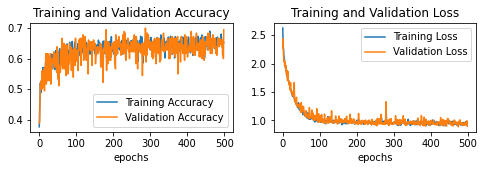

CPU times: user 2min 1s, sys: 1min 25s, total: 3min 26s
Wall time: 2min 34s


In [200]:
%%time
nn_multiClass_Classification(motions.classes[:5], batch_size=32)

number of classes: 28
train set:  (5017, 20) (5017, 28)
test set:  (2151, 20) (2151, 28)


2021-08-15 16:51:37.198173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-15 16:51:38.774556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 0s 7ms/step - loss: 2.2156 - accuracy: 0.3124


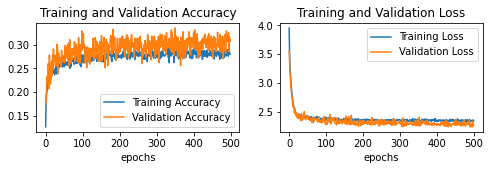

CPU times: user 10min 35s, sys: 7min 49s, total: 18min 24s
Wall time: 13min 27s


In [201]:
%%time
nn_multiClass_Classification(motions.classes, batch_size=32)